## CBAM模块代码 Resnet50核心模块
两种集成策略适用于不同的应用场景。模式一适合需要精细特征增强的任务，例如小样本数据集、细粒度分类、医学图像分析等场景，因为注意力机制能够更深入地参与到每个残差块的学习过程中。模式二适合计算资源有限或大规模数据集的场景，例如ImageNet预训练、目标检测和语义分割的主干网络等，它在保持注意力机制效果的同时显著降低了模型复杂度和计算开销。

In [2]:
"""
ResNet50+CBAM 语义分割网络
Windows环境兼容版本 - 增强版（包含Loss保存、模型保存、可视化）
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
import random
import sys
import json
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
class Bottleneck(nn.Module):
    """ResNet50的瓶颈块"""
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


# ==================== 语义分割网络 ====================

class ResNet50CBAM_Segmentation(nn.Module):
    """基于ResNet50+CBAM的语义分割网络"""

    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], num_classes=19, pretrained=False):
        super(ResNet50CBAM_Segmentation, self).__init__()

        self.inplanes = 64

        # 初始卷积层
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet编码器层
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.cbam1 = CBAM(64 * block.expansion)

        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.cbam2 = CBAM(128 * block.expansion)

        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.cbam3 = CBAM(256 * block.expansion)

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.cbam4 = CBAM(512 * block.expansion)

        # 解码器部分（U-Net风格）
        self.decoder4 = self._make_decoder_block(2048 + 1024, 256)
        self.decoder3 = self._make_decoder_block(256 + 512, 128)
        self.decoder2 = self._make_decoder_block(128 + 256, 64)
        self.decoder1 = self._make_decoder_block(64 + 64, 32)

        # 最终输出层
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

        # 权重初始化
        self._initialize_weights()

        # 加载预训练权重（可选）
        if pretrained:
            self._load_pretrained_weights()

    def _make_layer(self, block, planes, blocks, stride=1):
        """构建ResNet的层级"""
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def _make_decoder_block(self, in_channels, out_channels):
        """构建解码器块"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _initialize_weights(self):
        """初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_weights(self):
        """加载预训练的ResNet50权重"""
        try:
            pretrained_state_dict = model_zoo.load_url(
                'https://download.pytorch.org/models/resnet50-19c8e357.pth'
            )
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_state_dict.items() if k in model_dict}
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)
            print("成功加载ImageNet预训练权重")
        except Exception as e:
            print(f"警告: 加载预训练权重失败: {e}")

    def forward(self, x, size=None):
        """
        前向传播

        Args:
            x: 输入图像 [B, 3, H, W]
            size: 目标输出尺寸 (H_target, W_target)，默认为None时使用scale_factor=4
        """
        # 编码器部分
        x0 = self.conv1(x)           # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x0 = self.maxpool(x0)        # [B, 64, H/4, W/4]

        # Layer1 + CBAM
        x1 = self.layer1(x0)         # [B, 256, H/4, W/4]
        x1 = self.cbam1(x1)

        # Layer2 + CBAM
        x2 = self.layer2(x1)         # [B, 512, H/8, W/8]
        x2 = self.cbam2(x2)

        # Layer3 + CBAM
        x3 = self.layer3(x2)         # [B, 1024, H/16, W/16]
        x3 = self.cbam3(x3)

        # Layer4 + CBAM
        x4 = self.layer4(x3)         # [B, 2048, H/32, W/32]
        x4 = self.cbam4(x4)

        # 解码器部分
        # 1/32 -> 1/16
        h, w = x3.shape[2], x3.shape[3]
        x = F.interpolate(x4, size=(h, w), mode='bilinear', align_corners=False)
        x = torch.cat([x, x3], dim=1)
        x = self.decoder4(x)         # [B, 256, H/16, W/16]

        # 1/16 -> 1/8
        h, w = x2.shape[2], x2.shape[3]
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
        x = torch.cat([x, x2], dim=1)
        x = self.decoder3(x)         # [B, 128, H/8, W/8]

        # 1/8 -> 1/4
        h, w = x1.shape[2], x1.shape[3]
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
        x = torch.cat([x, x1], dim=1)
        x = self.decoder2(x)         # [B, 64, H/4, W/4]

        # 1/4 -> 1/2
        h, w = x0.shape[2], x0.shape[3]
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
        x = torch.cat([x, x0], dim=1)
        x = self.decoder1(x)         # [B, 32, H/4, W/4]

        # 最终卷积
        x = self.final_conv(x)       # [B, num_classes, H/4, W/4]

        # 最终上采样到原始尺寸
        if size is not None:
            target_h, target_w = size
            output = F.interpolate(x, size=(target_h, target_w), mode='bilinear', align_corners=False)
        else:
            output = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=False)

        return output


def resnet50_cbam_segmentation(num_classes=19, pretrained=False):
    """创建ResNet50+CBAM语义分割模型"""
    return ResNet50CBAM_Segmentation(
        Bottleneck, [3, 4, 6, 3],
        num_classes=num_classes,
        pretrained=pretrained
    )
#==================== ResNet50+CBAM语义分割模型完 ====================

In [2]:
# ==================== CBAM模块定义 ====================

class ChannelAttention(nn.Module):
    """通道注意力模块"""

    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    """空间注意力模块"""

    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class CBAM(nn.Module):
    """完整的CBAM注意力模块（通道+空间）"""

    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out

In [ ]:

# ==================== Cityscapes数据集加载 ====================
class CityscapesDataset(Dataset):
    """Cityscapes语义分割数据集"""
    CLASSES = [
        'road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
        'traffic light', 'traffic sign', 'vegetation', 'terrain',
        'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
        'motorcycle', 'bicycle'
    ]

    # 19类别的颜色映射 (RGB格式)
    CLASS_COLORS = {
        0: [128, 64, 128],     # road - 紫色
        1: [244, 35, 232],     # sidewalk - 粉色
        2: [70, 70, 70],       # building - 深灰
        3: [102, 102, 156],    # wall - 蓝灰
        4: [190, 153, 153],    # fence - 棕灰
        5: [153, 153, 153],    # pole - 灰
        6: [250, 170, 30],     # traffic light - 橙色
        7: [220, 220, 0],      # traffic sign - 黄色
        8: [107, 142, 35],     # vegetation - 绿色
        9: [152, 251, 152],    # terrain - 浅绿
        10: [70, 130, 180],    # sky - 天蓝
        11: [220, 20, 60],     # person - 红色
        12: [255, 0, 0],       # rider - 深红
        13: [0, 0, 142],       # car - 蓝色
        14: [0, 0, 70],        # truck - 深蓝
        15: [0, 60, 100],      # bus - 藏青
        16: [0, 80, 100],      # train - 青蓝
        17: [0, 0, 230],       # motorcycle - 靛蓝
        18: [119, 11, 32],     # bicycle - 紫红
        255: [0, 0, 0],        # ignore - 黑
    }

    LABEL_ID_MAPPING = {
        7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8,
        22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15,
        31: 16, 32: 17, 33: 18,
    }

    def __init__(self, root, split='train', transform=None, target_size=(1024, 512)):
        self.root = root
        self.split = split
        self.transform = transform
        self.target_size = target_size

        self.images = self._get_image_paths()
        self.targets = self._get_target_paths()

        print(f"Cityscapes {split} set: {len(self.images)} images")

    def _get_image_paths(self):
        """获取所有图像路径"""
        image_dir = os.path.join(self.root, 'leftImg8bit', self.split)
        images = []

        for city in os.listdir(image_dir):
            city_dir = os.path.join(image_dir, city)
            for img_name in os.listdir(city_dir):
                if img_name.endswith('_leftImg8bit.png'):
                    images.append(os.path.join(city_dir, img_name))

        return sorted(images)

    def _get_target_paths(self):
        """获取所有标注路径"""
        target_dir = os.path.join(self.root, 'gtFine', self.split)
        targets = []

        for img_path in self.images:
            img_name = os.path.basename(img_path)
            base_name = img_name.replace('_leftImg8bit.png', '')
            city = os.path.basename(os.path.dirname(img_path))
            target_name = f'{base_name}_gtFine_labelIds.png'
            target_path = os.path.join(target_dir, city, target_name)
            targets.append(target_path)

        return sorted(targets)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        """获取单个样本"""
        image = Image.open(self.images[idx]).convert('RGB')
        target = Image.open(self.targets[idx])

        # 保存原始尺寸
        original_size = image.size[::-1]  # (height, width)

        # 调整尺寸（用于训练）
        image = image.resize(self.target_size, Image.BILINEAR)
        target = target.resize(self.target_size, Image.NEAREST)

        # 应用增强
        if self.transform:
            image, target = self.transform(image, target)

        # 转换为张量
        image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float() / 255.0
        target = self._remap_labels(np.array(target))

        return image, target, original_size, self.images[idx]

    def _remap_labels(self, target):
        """将原始标签ID映射到类别索引"""
        remapped = np.full_like(target, 255)
        for old_id, new_id in self.LABEL_ID_MAPPING.items():
            remapped[target == old_id] = new_id
        return torch.from_numpy(remapped).long()


class SimpleTransform:
    """简单的数据增强"""

    def __init__(self, crop_size=(512, 512), flip_prob=0.5):
        self.crop_size = crop_size
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        # 随机水平翻转
        if random.random() < self.flip_prob:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            target = target.transpose(Image.FLIP_LEFT_RIGHT)

        # 随机裁剪
        crop_width, crop_height = self.crop_size
        image_width, image_height = image.size

        left = random.randint(0, image_width - crop_width)
        top = random.randint(0, image_height - crop_height)

        image = image.crop((left, top, left + crop_width, top + crop_height))
        target = target.crop((left, top, left + crop_width, top + crop_height))

        # 确保返回的是PIL Image
        if not isinstance(image, Image.Image):
            image = Image.fromarray(np.array(image))
        if not isinstance(target, Image.Image):
            target = Image.fromarray(np.array(target))

        return image, target


# ==================== 损失函数 ====================

class SegmentationLoss(nn.Module):
    """交叉熵损失函数"""

    def __init__(self, num_classes=19, ignore_index=255, weight=None):
        super(SegmentationLoss, self).__init__()
        self.ignore_index = ignore_index
        self.criterion = nn.CrossEntropyLoss(
            weight=weight,
            ignore_index=ignore_index,
            reduction='mean'
        )

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()
        loss = self.criterion(pred, target)
        return loss


class DiceLoss(nn.Module):
    """Dice损失函数"""

    def __init__(self, num_classes=19, ignore_index=255, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, pred, target):
        num_classes = pred.shape[1]
        pred = F.softmax(pred, dim=1)

        total_loss = 0
        for cls in range(num_classes):
            pred_cls = pred[:, cls, :, :]
            target_cls = (target == cls).float()

            valid_mask = (target != self.ignore_index)
            pred_cls = pred_cls * valid_mask
            target_cls = target_cls * valid_mask

            intersection = (pred_cls * target_cls).sum()
            dice_loss = 1 - (2. * intersection + self.smooth) / (
                pred_cls.sum() + target_cls.sum() + self.smooth
            )
            total_loss += dice_loss

        return total_loss / num_classes


class CombinedLoss(nn.Module):
    """组合损失函数（CE + Dice）"""

    def __init__(self, num_classes=19, ignore_index=255, ce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.ce_loss = SegmentationLoss(num_classes, ignore_index)
        self.dice_loss = DiceLoss(num_classes, ignore_index)
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight

    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        return self.ce_weight * ce + self.dice_weight * dice


# ==================== 可视化工具函数 ====================

def plot_loss_curve(train_losses, val_losses, save_path='loss_curve.png'):
    """
    绘制并保存loss曲线

    Args:
        train_losses: 训练loss列表
        val_losses: 验证loss列表
        save_path: 保存路径
    """
    plt.figure(figsize=(12, 5))

    # 训练loss曲线
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training Loss Curve', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 验证loss曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Validation Loss Curve', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Loss曲线已保存至: {save_path}")


def create_overlay_image(original_image, prediction, alpha=0.25):
    """
    将分割结果以指定透明度叠加到原始图像上

    Args:
        original_image: 原始图像 (PIL Image)
        prediction: 分割预测结果 (numpy数组, H, W)
        alpha: 叠加透明度 (0-1之间)，默认0.25表示25%透明度

    Returns:
        overlayed_image: 叠加后的PIL Image
    """
    # 调整预测结果尺寸以匹配原始图像
    orig_w, orig_h = original_image.size
    prediction_resized = np.array(Image.fromarray(prediction.astype(np.uint16)).resize(
        (orig_w, orig_h), Image.NEAREST
    ))

    # 创建彩色分割掩码
    h, w = prediction_resized.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in CityscapesDataset.CLASS_COLORS.items():
        if class_id != 255:
            colored_mask[prediction_resized == class_id] = color

    mask_image = Image.fromarray(colored_mask)

    # 使用PIL的blend函数进行25%透明度叠加
    overlayed_image = Image.blend(original_image, mask_image, alpha=alpha)

    return overlayed_image


# ==================== 增强的训练器 ====================

class SegmentationTrainer:
    """语义分割训练器 - 增强版（包含Loss保存和模型保存）"""

    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device,
                 save_dir='checkpoints'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        # 创建保存目录
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

        # Loss记录
        self.train_losses = []
        self.val_losses = []
        self.val_miou_history = []

        self.best_miou = 0
        self.epoch = 0

    def train_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0

        for batch_idx, (images, targets, _, _) in enumerate(self.train_loader):
            images = images.to(self.device)
            targets = targets.to(self.device)

            outputs = self.model(images, size=None)
            loss = self.criterion(outputs, targets)

            total_loss += loss.item()

            # 反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if self.scheduler:
                self.scheduler.step()

            if batch_idx % 50 == 0:
                print(f"  Batch {batch_idx}/{len(self.train_loader)}, Loss: {loss.item():.4f}")

        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def validate(self):
        """验证"""
        self.model.eval()
        total_loss = 0
        confusion_matrix = np.zeros((19, 19))

        for images, targets, _, _ in self.val_loader:
            images = images.to(self.device)
            targets = targets.to(self.device)

            outputs = self.model(images, size=None)
            loss = self.criterion(outputs, targets)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            for t, p in zip(targets.cpu().numpy(), preds.cpu().numpy()):
                for gt, pred in zip(t.flatten(), p.flatten()):
                    if gt != 255:
                        confusion_matrix[gt, pred] += 1

        intersection = np.diag(confusion_matrix)
        union = confusion_matrix.sum(axis=1) + confusion_matrix.sum(axis=0) - intersection
        iou = intersection / (union + 1e-10)
        miou = np.mean(iou[iou > 0])

        return total_loss / len(self.val_loader), miou

    def save_loss_history(self, filename='loss_history.json'):
        """保存loss历史记录到JSON文件"""
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_miou_history': self.val_miou_history
        }
        filepath = os.path.join(self.save_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(history, f, indent=2)
        print(f"Loss历史记录已保存至: {filepath}")

    def save_final_model(self, filename='final_model.pth'):
        """保存最终模型参数"""
        filepath = os.path.join(self.save_dir, filename)
        torch.save({
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_miou': self.best_miou
        }, filepath)
        print(f"最终模型已保存至: {filepath}")
        return filepath

    def train(self, num_epochs, save_path='best_model.pth'):
        """完整训练流程"""
        print("=" * 60)
        print("开始训练 ResNet50+CBAM 语义分割模型")
        print("=" * 60)

        # 完整的保存路径
        best_model_path = os.path.join(self.save_dir, save_path)

        for epoch in range(num_epochs):
            self.epoch = epoch
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)

            train_loss = self.train_epoch()
            val_loss, val_miou = self.validate()

            # 记录loss
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_miou_history.append(val_miou)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}, mIoU: {val_miou:.4f}")

            if val_miou > self.best_miou:
                self.best_miou = val_miou
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'miou': val_miou
                }, best_model_path)
                print(f"保存最佳模型！mIoU: {val_miou:.4f}")

            # 每5个epoch保存一次loss历史
            if (epoch + 1) % 5 == 0:
                self.save_loss_history()

        print("\n" + "=" * 60)
        print("训练完成！开始保存最终结果...")
        print("=" * 60)

        # 保存最终模型
        self.save_final_model('final_model.pth')

        # 绘制并保存loss曲线
        loss_curve_path = os.path.join(self.save_dir, 'loss_curve.png')
        plot_loss_curve(self.train_losses, self.val_losses, save_path=loss_curve_path)

        # 最终保存loss历史
        self.save_loss_history()

        print(f"\n训练完成！最佳mIoU: {self.best_miou:.4f}")
        return self.best_miou


# ==================== 测试和可视化函数 ====================

def test_and_visualize(model, data_loader, device, save_dir='test_results', num_samples=20):
    """
    测试模型并可视化分割结果

    Args:
        model: 训练好的模型
        data_loader: 数据加载器
        device: 设备
        save_dir: 保存目录
        num_samples: 可视化样本数量
    """
    print("\n" + "=" * 60)
    print("开始生成测试可视化结果...")
    print("=" * 60)

    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    overlayed_dir = os.path.join(save_dir, 'overlayed_results')
    mask_dir = os.path.join(save_dir, 'segmentation_masks')
    os.makedirs(overlayed_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    model.eval()
    model.to(device)

    total_iou = []
    sample_count = 0

    with torch.no_grad():
        for images, targets, original_sizes, image_paths in data_loader:
            if sample_count >= num_samples:
                break

            images = images.to(device)
            outputs = model(images, size=None)
            preds = outputs.argmax(dim=1)

            batch_size = images.size(0)
            for i in range(min(batch_size, num_samples - sample_count)):
                # 获取原始图像
                original_img = np.clip(images[i].cpu().permute(1, 2, 0).numpy() * 255, 0, 255).astype(np.uint8)
                original_pil = Image.fromarray(original_img)

                # 获取预测结果
                pred = preds[i].cpu().numpy()
                target = targets[i].numpy()

                # 获取原始尺寸
                orig_h = original_sizes[0][i].item()
                orig_w = original_sizes[1][i].item()

                # 计算该样本的IoU
                valid_mask = (target != 255) & (pred != 255)
                if valid_mask.sum() > 0:
                    intersection = ((pred == target) & valid_mask).sum()
                    union = valid_mask.sum()
                    iou = intersection / (union + 1e-10)
                    total_iou.append(iou)

                # 创建彩色分割掩码
                pred_resized = np.array(Image.fromarray(pred.astype(np.uint16)).resize(
                    (orig_w, orig_h), Image.NEAREST
                ))

                colored_mask = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
                for class_id, color in CityscapesDataset.CLASS_COLORS.items():
                    if class_id != 255:
                        colored_mask[pred_resized == class_id] = color
                mask_pil = Image.fromarray(colored_mask)

                # 保存分割掩码
                mask_filename = f'sample_{sample_count + 1:04d}_mask.png'
                mask_path = os.path.join(mask_dir, mask_filename)
                mask_pil.save(mask_path)

                # 创建25%透明度叠加图像
                original_pil_resized = original_pil.resize((orig_w, orig_h), Image.BILINEAR)
                mask_resized = mask_pil.resize((orig_w, orig_h), Image.NEAREST)
                overlayed = Image.blend(original_pil_resized, mask_resized, alpha=0.25)

                # 保存叠加结果
                overlay_filename = f'sample_{sample_count + 1:04d}_overlay.png'
                overlayed_path = os.path.join(overlayed_dir, overlay_filename)
                overlayed.save(overlayed_path)

                # 获取原始图像文件名
                original_filename = os.path.basename(image_paths[i])
                iou_value = total_iou[-1] if total_iou else 0

                print(f"样本 {sample_count + 1}: IoU={iou_value:.4f}")
                print(f"  - 原始图像: {original_filename}")
                print(f"  - 分割掩码: {mask_path}")
                print(f"  - 叠加图像(25%透明度): {overlayed_path}")

                sample_count += 1

    # 保存测试报告
    if total_iou:
        avg_iou = np.mean(total_iou)
        report = {
            'num_samples': len(total_iou),
            'average_iou': float(avg_iou),
            'iou_list': [float(iou) for iou in total_iou],
            'save_dir': save_dir
        }
        report_path = os.path.join(save_dir, 'test_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2)
        print(f"\n测试报告已保存至: {report_path}")
        print(f"平均IoU: {avg_iou:.4f}")

    print(f"\n测试完成！共生成 {sample_count} 个可视化样本")
    print(f"分割掩码保存在: {mask_dir}")
    print(f"叠加结果保存在: {overlayed_dir}")


# ==================== 训练配置和启动 ====================

def setup_training(data_root, batch_size=8, num_classes=19, learning_rate=1e-4,
                   num_epochs=50, num_workers=0, save_dir='checkpoints'):
    """配置并启动训练"""

    # 设备配置
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")

    # 检查GPU状态
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

    # 创建数据集
    train_transform = SimpleTransform(crop_size=(512, 512))

    train_dataset = CityscapesDataset(
        root=data_root,
        split='train',
        transform=train_transform,
        target_size=(1024, 512)
    )

    val_dataset = CityscapesDataset(
        root=data_root,
        split='val',
        target_size=(1024, 512)
    )

    # 创建数据加载器（Windows环境使用num_workers=0）
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    # 创建模型
    print("\n创建模型...")
    model = resnet50_cbam_segmentation(
        num_classes=num_classes,
        pretrained=True
    ).to(device)

    # 统计参数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"总参数数量: {total_params:,}")
    print(f"可训练参数: {trainable_params:,}")

    # 创建损失函数和优化器
    criterion = CombinedLoss(num_classes=num_classes)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.PolynomialLR(
        optimizer, total_iters=len(train_loader) * num_epochs, power=0.9
    )

    # 创建训练器（添加save_dir参数）
    trainer = SegmentationTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        save_dir=save_dir
    )

    # 开始训练
    best_miou = trainer.train(num_epochs=num_epochs)

    print(f"\n最终结果:")
    print(f"  最佳验证mIoU: {best_miou:.4f}")

    return model, trainer


def main():
    """主函数 - 增强版"""
    # 配置参数（请修改为您的实际路径）
    data_root = "E:\\Laboratory files\\code_project\\city_data"  # 您的Cityscapes数据集路径 E:\Laboratory files\code_project\city_data\leftImg8bit\train\aachen
    batch_size = 4  # 根据您的GPU显存调整
    num_classes = 19
    learning_rate = 1e-4
    num_epochs = 50
    num_workers = 0  # Windows环境必须设置为0
    save_dir = 'checkpoints'  # 模型和loss保存目录
    test_samples = 20  # 测试时可视化的样本数量

    print("=" * 60)
    print("ResNet50+CBAM 语义分割训练 - 增强版")
    print("=" * 60)
    print(f"数据路径: {data_root}")
    print(f"批次大小: {batch_size}")
    print(f"学习率: {learning_rate}")
    print(f"训练轮数: {num_epochs}")
    print(f"模型保存目录: {save_dir}")
    print("=" * 60)

    # 创建模型目录
    os.makedirs(save_dir, exist_ok=True)

    # 训练
    model, trainer = setup_training(
        data_root=data_root,
        batch_size=batch_size,
        num_classes=num_classes,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        num_workers=num_workers,
        save_dir=save_dir
    )

    # 训练完成后自动进行测试和可视化
    print("\n" + "=" * 60)
    print("训练完成，开始生成测试可视化结果...")
    print("=" * 60)

    # 使用验证集进行测试可视化
    test_dataset = CityscapesDataset(
        root=data_root,
        split='val',
        target_size=(1024, 512)
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,  # 测试时使用batch_size=1便于逐个处理
        shuffle=False,
        num_workers=0
    )

    # 测试并可视化
    test_and_visualize(
        model=model,
        data_loader=test_loader,
        device=next(model.parameters()).device,
        save_dir='test_results',
        num_samples=test_samples
    )

    print("\n" + "=" * 60)
    print("所有任务完成！")
    print("=" * 60)
    print(f"最佳模型: {os.path.join(save_dir, 'best_model.pth')}")
    print(f"最终模型: {os.path.join(save_dir, 'final_model.pth')}")
    print(f"Loss历史: {os.path.join(save_dir, 'loss_history.json')}")
    print(f"Loss曲线: {os.path.join(save_dir, 'loss_curve.png')}")
    print(f"测试结果: test_results/overlayed_results/")

    return model, trainer


# Windows环境必须添加的保护
if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"训练过程中出错: {e}")
        import traceback
        traceback.print_exc()

Successfully loaded data! Total Epochs: 50

==================== Key Metrics Summary ====================
Minimum Train Loss: 0.114220 (Epoch 50)
Minimum Val Loss: 0.209880 (Epoch 50)
Maximum Val mIoU: 0.808990 (Epoch 48)
Final Train Loss: 0.114220
Final Val Loss: 0.209880
Final Val mIoU: 0.760120

浅色背景图表已保存至: loss_curve.png


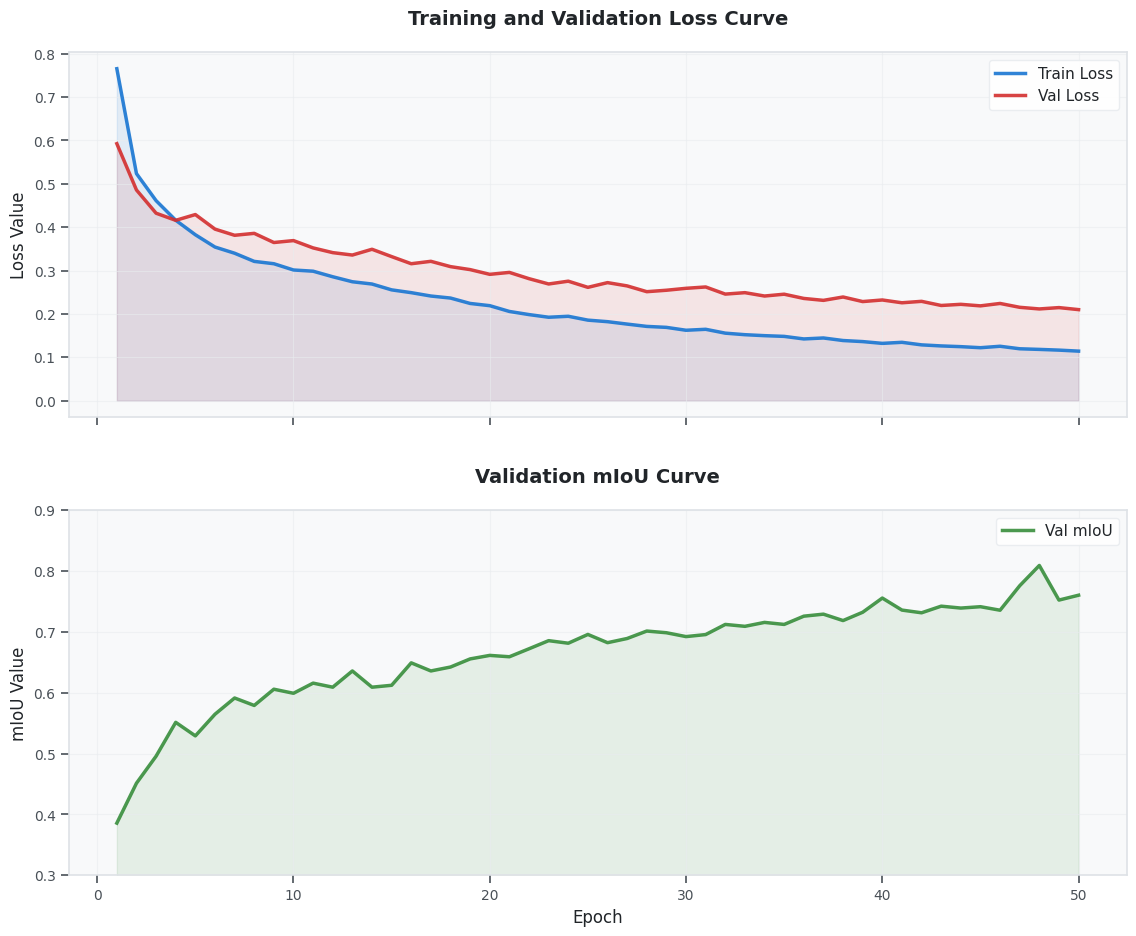

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 设置全局样式 - 浅色背景配置
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 通用无衬线字体（兼容中英文）
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.facecolor'] = 'white'        # 画布背景色
plt.rcParams['axes.facecolor'] = '#f8f9fa'        # 坐标轴背景色（浅灰）
plt.rcParams['grid.color'] = '#e9ecef'            # 网格线颜色
plt.rcParams['axes.edgecolor'] = '#dee2e6'        # 坐标轴边框色
plt.rcParams['text.color'] = '#212529'            # 文字颜色
plt.rcParams['axes.labelcolor'] = '#212529'
plt.rcParams['xtick.color'] = '#495057'
plt.rcParams['ytick.color'] = '#495057'

def load_loss_data(file_path):
    """
    从JSON文件加载损失和mIoU数据
    :param file_path: JSON文件路径
    :return: 训练损失列表、验证损失列表、验证mIoU列表
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    train_losses = data['train_losses']
    val_losses = data['val_losses']
    val_miou = data['val_miou_history']
    return train_losses, val_losses, val_miou

def plot_loss_and_miou(train_losses, val_losses, val_miou, save_path='loss_miou_curve_light.png'):
    """
    绘制训练/验证损失曲线和验证mIoU曲线（浅色背景版）
    :param train_losses: 训练损失列表
    :param val_losses: 验证损失列表
    :param val_miou: 验证mIoU列表
    :param save_path: 图片保存路径
    """
    # 生成迭代次数（epoch）
    epochs = np.arange(1, len(train_losses) + 1)

    # 创建画布，设置大小
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # --------------------- 绘制损失曲线 ---------------------
    # 训练损失：深蓝色 + 轻微填充
    ax1.plot(epochs, train_losses, '#1976D2', linewidth=2.5, label='Train Loss', alpha=0.9)
    ax1.fill_between(epochs, train_losses, alpha=0.1, color='#1976D2')
    # 验证损失：深红色 + 轻微填充
    ax1.plot(epochs, val_losses, '#D32F2F', linewidth=2.5, label='Val Loss', alpha=0.9)
    ax1.fill_between(epochs, val_losses, alpha=0.1, color='#D32F2F')

    ax1.set_title('Training and Validation Loss Curve', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.grid(True, alpha=0.6, linestyle='-', linewidth=0.8)
    ax1.legend(fontsize=11, framealpha=0.9, facecolor='white', edgecolor='#e9ecef')
    ax1.tick_params(axis='both', labelsize=10, length=6, width=1.2)

    # 设置坐标轴背景和边框
    ax1.set_facecolor('#f8f9fa')
    for spine in ax1.spines.values():
        spine.set_color('#dee2e6')
        spine.set_linewidth(1.2)

    # --------------------- 绘制mIoU曲线 ---------------------
    # 验证mIoU：深绿色 + 轻微填充
    ax2.plot(epochs, val_miou, '#388E3C', linewidth=2.5, label='Val mIoU', alpha=0.9)
    ax2.fill_between(epochs, val_miou, alpha=0.1, color='#388E3C')

    ax2.set_title('Validation mIoU Curve', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('mIoU Value', fontsize=12)
    ax2.set_ylim(0.3, 0.9)  # 适配数据范围，更聚焦
    ax2.grid(True, alpha=0.6, linestyle='-', linewidth=0.8)
    ax2.legend(fontsize=11, framealpha=0.9, facecolor='white', edgecolor='#e9ecef')
    ax2.tick_params(axis='both', labelsize=10, length=6, width=1.2)

    # 设置坐标轴背景和边框
    ax2.set_facecolor('#f8f9fa')
    for spine in ax2.spines.values():
        spine.set_color('#dee2e6')
        spine.set_linewidth(1.2)

    # 调整子图间距
    plt.tight_layout(pad=3.0)

    # 保存图片（高分辨率，透明背景可选）
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"浅色背景图表已保存至: {save_path}")

    # 显示图表
    plt.show()

def print_key_metrics(train_losses, val_losses, val_miou):
    """
    打印关键指标（最小损失、最高mIoU等）
    """
    # 计算关键指标
    min_train_loss = min(train_losses)
    min_train_loss_epoch = train_losses.index(min_train_loss) + 1

    min_val_loss = min(val_losses)
    min_val_loss_epoch = val_losses.index(min_val_loss) + 1

    max_miou = max(val_miou)
    max_miou_epoch = val_miou.index(max_miou) + 1

    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    final_miou = val_miou[-1]

    # 打印结果
    print("\n==================== Key Metrics Summary ====================")
    print(f"Minimum Train Loss: {min_train_loss:.6f} (Epoch {min_train_loss_epoch})")
    print(f"Minimum Val Loss: {min_val_loss:.6f} (Epoch {min_val_loss_epoch})")
    print(f"Maximum Val mIoU: {max_miou:.6f} (Epoch {max_miou_epoch})")
    print(f"Final Train Loss: {final_train_loss:.6f}")
    print(f"Final Val Loss: {final_val_loss:.6f}")
    print(f"Final Val mIoU: {final_miou:.6f}")
    print("==============================================================\n")

if __name__ == '__main__':
    # 配置文件路径（使用你提供的loss_history.json）
    json_file_path = 'loss_gemini.json'

    # 加载数据
    try:
        train_losses, val_losses, val_miou = load_loss_data(json_file_path)
        print(f"Successfully loaded data! Total Epochs: {len(train_losses)}")

        # 打印关键指标
        print_key_metrics(train_losses, val_losses, val_miou)

        # 绘制并保存浅色背景图表
        plot_loss_and_miou(train_losses, val_losses, val_miou, 'loss_curve.png')

    except FileNotFoundError:
        print(f"Error: File {json_file_path} not found, please check the path")
    except KeyError as e:
        print(f"Error: Missing key in JSON file - {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")

## =================== 1. 自适应双向引导交互模块 ====================